In [1]:
import numpy as np

# Данные 
* retina-представления событий с ks и без.

In [2]:
sig = np.load("./mc_ks_retina.npy")
bg = np.load("./mc_bg_retina.npy")

In [5]:
X = np.vstack([sig,bg])
X =  X.reshape([len(X),1,64,64])
y = np.zeros( [len(sig)+len(bg),2])
y[:len(sig),1] = 1
y[len(sig):,0] = 1
#y = y[:,1]==0

# keras nn

In [220]:
import keras
import keras.models as model
import keras.layers.convolutional as lconv
import keras.layers.core as lcore

NN = model.Sequential()
#NN.add(lconv.Convolution2D(32,nb_row=12,nb_col=12,
#                           activation=keras.activations.relu,
#                           input_shape=(1, 100,100))
#       
#      )

#NN.add(lconv.MaxPooling2D(pool_size=(4, 4)))

#NN.add(lconv.Convolution2D(32,nb_row=5,nb_col=5,
#                           activation=keras.activations.relu)
#      )

#NN.add(lconv.MaxPooling2D(pool_size=(2, 2)))
NN.add(lcore.Flatten(input_shape=(1, 100,100)))
#NN.add(lcore.Dropout(0.5))
NN.add(lcore.Dense(256))
NN.add(lcore.Activation(keras.activations.sigmoid))
NN.add(lcore.Dropout(0.2))
NN.add(lcore.Dense(128))
NN.add(lcore.Activation(keras.activations.sigmoid))
NN.add(lcore.Dropout(0.2))
NN.add(lcore.Dense(2,))
NN.add(lcore.Activation(keras.activations.softmax))

In [221]:
from keras.optimizers import Adagrad,RMSprop,Adadelta,SGD

NN.compile(loss=keras.objectives.categorical_crossentropy, optimizer=SGD(lr=0.005))

In [222]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.25)
Xtr.shape,Yts.shape

((4506, 1, 100, 100), (1503, 2))

In [223]:
import theano
theano.config.openmp=True

In [224]:
NN.fit(Xtr,Ytr,
       batch_size=64, nb_epoch=200,
       show_accuracy=True, verbose=2,
       validation_data = (Xts,Yts))

Train on 4506 samples, validate on 1503 samples
Epoch 1/200
3s - loss: 0.7244 - acc: 0.5087 - val_loss: 0.6929 - val_acc: 0.5196
Epoch 2/200
4s - loss: 0.7183 - acc: 0.5022 - val_loss: 0.6902 - val_acc: 0.5403
Epoch 3/200
3s - loss: 0.7137 - acc: 0.5140 - val_loss: 0.6885 - val_acc: 0.5216
Epoch 4/200
3s - loss: 0.7107 - acc: 0.5140 - val_loss: 0.6909 - val_acc: 0.5276
Epoch 5/200
3s - loss: 0.7118 - acc: 0.5180 - val_loss: 0.6870 - val_acc: 0.5629
Epoch 6/200
4s - loss: 0.7104 - acc: 0.5142 - val_loss: 0.6857 - val_acc: 0.5609
Epoch 7/200
3s - loss: 0.7059 - acc: 0.5226 - val_loss: 0.6848 - val_acc: 0.5689
Epoch 8/200
3s - loss: 0.7011 - acc: 0.5313 - val_loss: 0.6852 - val_acc: 0.5662
Epoch 9/200
3s - loss: 0.7014 - acc: 0.5255 - val_loss: 0.6861 - val_acc: 0.5403
Epoch 10/200
4s - loss: 0.6985 - acc: 0.5317 - val_loss: 0.6823 - val_acc: 0.5941
Epoch 11/200
4s - loss: 0.6961 - acc: 0.5413 - val_loss: 0.6822 - val_acc: 0.5436
Epoch 12/200
3s - loss: 0.6912 - acc: 0.5375 - val_loss: 0.

In [ ]:
NN.predict(new_)

# лазаниевые зарисовки

In [31]:
import lasagne as lg
import lasagne.layers as ly

In [44]:
def build_nn(inp):
    l_inp = ly.InputLayer(shape = [None,1,100,100],input_var=inp)

    l_conv1 = ly.Conv2DLayer(
            l_inp, num_filters=32, filter_size=(5, 5),
            nonlinearity=lg.nonlinearities.rectify,
            W=lg.init.GlorotUniform())

    l_mpool1 = ly.MaxPool2DLayer(l_conv1, pool_size=(2, 2))

    l_conv2 = ly.Conv2DLayer(
            l_mpool1, 
            num_filters=64, filter_size=(5, 5),
            nonlinearity=lg.nonlinearities.rectify,
            #stride=(3,3),
            )

    l_mpool2 = ly.MaxPool2DLayer(l_conv2, pool_size=(2, 2))


    l_dense1 = ly.DenseLayer(
            ly.dropout(l_mpool2, p=.5),
            num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify)

    l_dense2 = ly.DenseLayer(
            ly.dropout(l_dense1, p=.5),
            num_units=32,
            nonlinearity=lasagne.nonlinearities.rectify)
    return l_dense2

In [55]:
from theano import tensor as T
import theano

#nn
inp = T.tensor4("pic-tensor")
nn = build_nn(inp)
nn_out = ly.get_output(nn)

#loss
ref_out = T.ivector("ks")
loss = lg.objectives.categorical_crossentropy(nn_out,ref_out)
loss = loss.mean()


#training
params = ly.get_all_params(nn,trainable=True)

updates = lg.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

train_fn = theano.function([inp, ref_out], loss, updates=updates)


#test loss
test_nn_out = ly.get_output(nn, deterministic=True)
test_loss = lg.objectives.categorical_crossentropy(test_nn_out,ref_out)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_nn_out, axis=1), ref_out),
                  dtype=theano.config.floatX)

validation_fn = theano.function([inp, ref_out], [test_loss, test_acc])


In [50]:
###training

for epoch in range(num_epochs):
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        train_fn(inputs, targets)

In [91]:
from sklearn.decomposition import PCA

In [132]:
pca = PCA(n_components=256).fit(Xtr.reshape(len(Xtr),np.prod(Xtr.shape[1:])))

In [133]:
Xpca = pca.transform(X.reshape(len(X),np.prod(X.shape[1:])))

In [134]:
from matplotlib import pyplot as plt
%matplotlib inline

<matplotlib.colorbar.Colorbar instance at 0x7f5f590582d8>

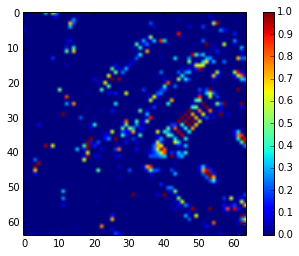

In [135]:
from random import choice
i = choice(range(100))
plt.imshow(X[:,0][y[:,0]==0][i],vmin=0,vmax=1)
plt.colorbar()

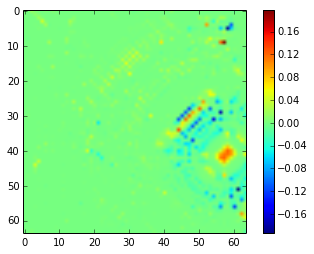

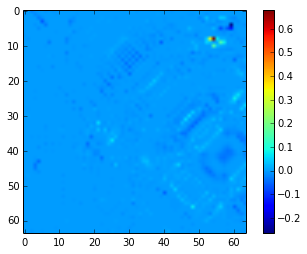

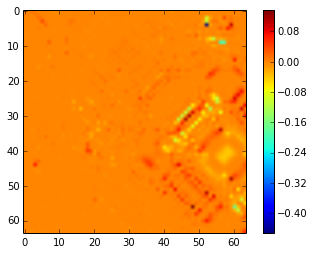

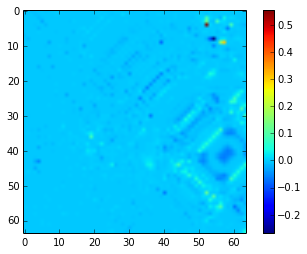

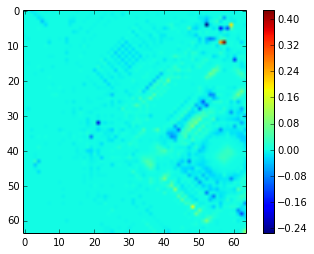

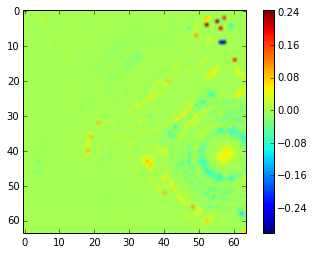

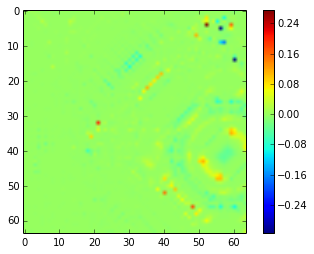

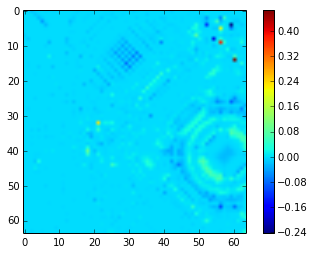

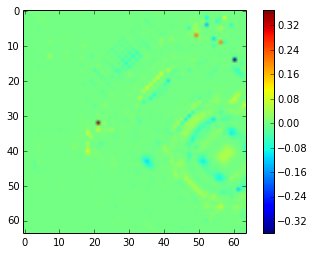

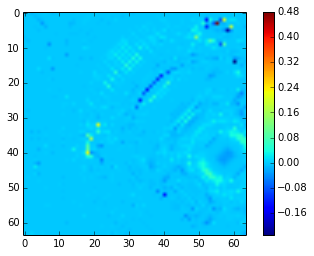

In [136]:
for i in range(10,20):
    plt.imshow(pca.components_[i].reshape(64,64))
    plt.colorbar()
    plt.show()

In [131]:
pca.components_.shape

(256, 256)

In [11]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier


In [137]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X.reshape(len(X),np.prod(X.shape[1:])),y[:,1]==1,test_size=0.25)

In [138]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(Xpca,y[:,1]==1,test_size=0.25)

In [139]:
model = LogisticRegression(penalty='l2',C=0.05).fit(Xtr,Ytr)

In [140]:
from sklearn.metrics import roc_auc_score
print "train auc",roc_auc_score(Ytr,model.predict_proba(Xtr)[:,1])
print "test auc",roc_auc_score(Yts,model.predict_proba(Xts)[:,1])

train auc 0.996935735565
test auc 0.995331823354


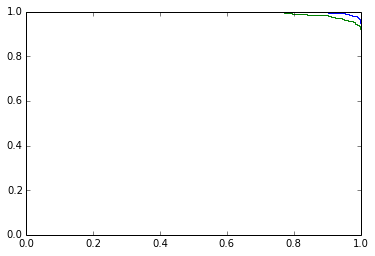

In [124]:
from sklearn.metrics import roc_curve

fpr,tpr,_ = roc_curve(Ytr,model.predict_proba(Xtr)[:,1])
plt.plot(1-fpr,tpr)
fpr,tpr,_ = roc_curve(Yts,model.predict_proba(Xts)[:,1])
plt.plot(1-fpr,tpr)

In [125]:
from sklearn.metrics import accuracy_score
print "train accuracy",accuracy_score(Ytr,model.predict(Xtr))
print "test accuracy",accuracy_score(Yts,model.predict(Xts))

train accuracy 0.96648912561
test accuracy 0.958083832335


<matplotlib.colorbar.Colorbar instance at 0x7f5f591f33f8>

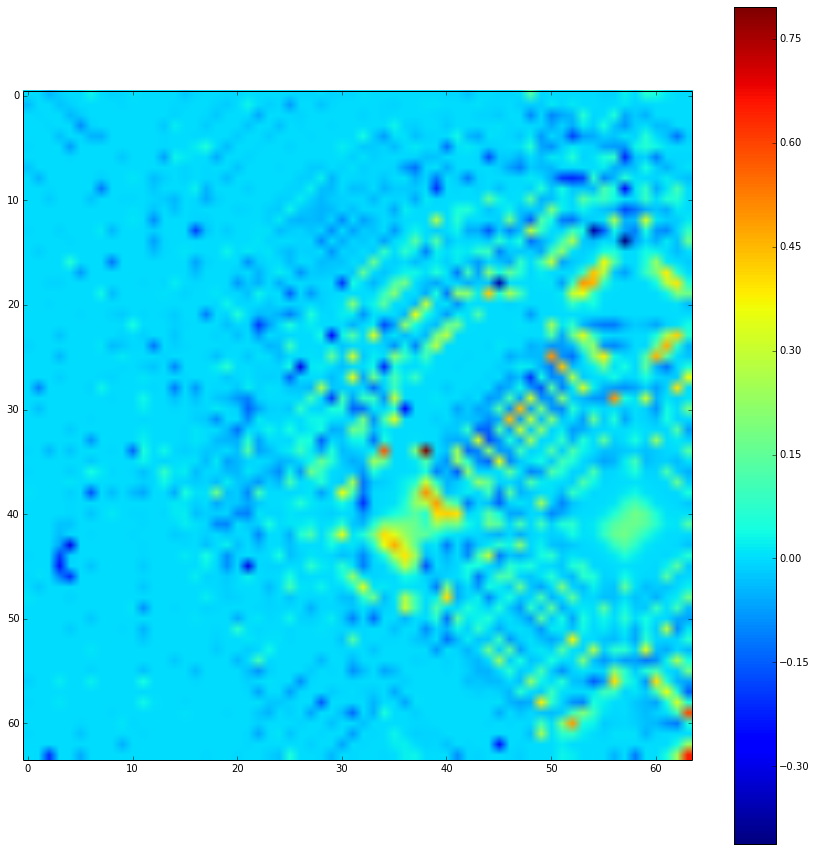

In [126]:
plt.figure(figsize=[15,15])
cfc = np.array(model.coef_)
plt.imshow(cfc.reshape(64,64))
plt.colorbar()

In [29]:
cfc.shape

(1, 10000)